## Segmentation Explainability

In [5]:
!pip install segmentation_models_pytorch albumentations grad-cam

  Using cached segmentation_models_pytorch-0.3.3-py3-none-any.whl (106 kB)
  Using cached timm-0.9.2-py3-none-any.whl (2.2 MB)
  Using cached pretrainedmodels-0.7.4-py3-none-any.whl
  Using cached efficientnet_pytorch-0.7.1-py3-none-any.whl
  Using cached safetensors-0.4.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

import matplotlib.pyplot as plt

In [17]:
DATA_ROOT = "/home/datascience/ISVC_2023_Tutorial_XAI_Few_Shot_on_the_Cloud/SampleDataset(s)/Few_Shot/Segmentation"
SAVE_DIR = "checkpoints"
SHOT = 10

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/home/datascience/conda/pytorch110_p38_gpu_v1/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
class GradCamSampler(nn.Module):
    def __init__(self, img_root, mask_root, image_files, mask_files, transforms=None, preprocessing=None, samples_to_generate=5):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.samples_to_generate = samples_to_generate
        self.transforms = transforms
        self.preprocessing = preprocessing

    def _sample_images_for_gradcam(self):
        sample_ids = np.random.choice(range(len(self.img_files)), size=self.samples_to_generate)
        self.ids = sample_ids

    def __len__(self):
        return self.samples_to_generate
    
    def __getitem__(self, idx):
        image = np.array(Image.open(os.path.join(self.img_root, self.img_files[idx])))
        mask = np.array(Image.open(os.path.join(self.mask_root, self.mask_files[idx])))
        
        # image = np.stack([image, image, image], axis=-1)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        # mask = torch.unsqueeze(mask, 0)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image)
            image = transformed["image"]
            # mask = transformed["mask"]
            
        return image.type(torch.FloatTensor), mask/255.0

In [15]:
test_images = os.listdir(f"{DATA_ROOT}/{SHOT}-shot/test/images")
augmentations = A.Compose([A.Resize(256, 256), ToTensorV2()])

test_set = GradCamSampler(f"{DATA_ROOT}/{SHOT}-shot/test/images",
                            f"{DATA_ROOT}/{SHOT}-shot/test/labels",
                            test_images, test_images, 
                            preprocessing=None,
                            transforms=augmentations)

In [21]:
# model = torch.load(f"{SAVE_DIR}/best_model_{SHOT}_shot.pt")
model = torch.load("best_model.pth")
model = model.to(DEVICE)

In [22]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
test_img, test_mask  = next(iter(test_loader))

In [23]:
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        if type(mask) == np.array:
            self.mask = torch.from_numpy(mask)
        else:
            self.mask = mask

        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        print(self.mask.shape == model_output.shape)
        return (model_output[self.category,:,:] * self.mask).sum()

True
tensor(0.6133)
True
tensor(0.8417)
True
tensor(0.8560)
True
tensor(0.8545)
True
tensor(0.8152)


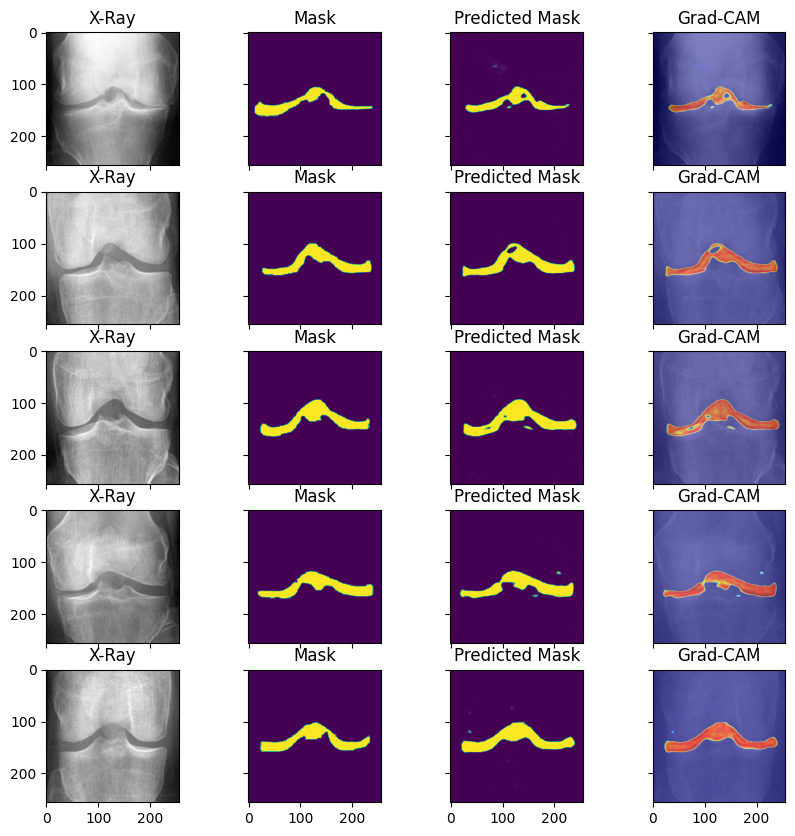

In [28]:
target_layers = [model.decoder, model.segmentation_head]
iou = smp_utils.metrics.IoU(threshold=0.5)
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:

    fig, ax = plt.subplots(len(test_loader), 4, figsize=(10, 10), sharex=True, sharey=True)

    for i, (test_img, test_mask) in enumerate(test_loader):
        targets = [SemanticSegmentationTarget(0, test_mask)]

        grayscale_cam = cam(input_tensor=test_img,
                            targets=targets)[0, :]

        test_img2= test_img.squeeze().squeeze().detach().cpu().numpy()/255.0
        test_img2 = np.stack([test_img2, test_img2, test_img2], axis=-1)

        cam_image = show_cam_on_image(test_img2, grayscale_cam, use_rgb=True)
        out = model(test_img.to(DEVICE))

        ax[i, 0].imshow(test_img[0][0,:,:].squeeze(),cmap="gray")
        ax[i, 0].set_title("X-Ray")
        ax[i, 1].imshow(test_mask.squeeze())
        ax[i, 1].set_title("Mask")
        ax[i, 2].imshow(torch.sigmoid(out).squeeze().detach().cpu().numpy())
        ax[i, 2].set_title("Predicted Mask")
        ax[i, 3].imshow(Image.fromarray(cam_image))
        ax[i, 3].set_title("Grad-CAM")

        print(iou(out.detach().cpu().squeeze(), test_mask.squeeze()))